# Description - Create SWARM File for Power Spectrum generation for each ROI

This notebook will:

1. Load lists of all, drowsy and awake scans.
2. If needed, you can also restrict the scan lists to only those with no overlap between aliasedHR and sleep band by running the clearly marker selection cell
3. Generate Panel A of Figure 5
4. Look for frequencies with statistical differences

> Link about units for PSD: DBs description in https://stackoverflow.com/questions/15255632/what-is-the-psd-unit-by-using-fft-method (Yet we will not work with DBs)

***
# Import Libraries

In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
from utils.variables import Resources_Dir, DATA_DIR
from utils.basics import get_available_runs

from scipy.stats import kruskal, wilcoxon, ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Use the Group Level V4 ROI for these analyses

In [2]:
region='V4lt_grp'
suffix='mPP'
remove_HRa_scans = True

# Spectral Analysis for iFV - whole run - Figure

### Load Scan Lists

In [3]:
Manuscript_Runs = get_available_runs(when='final')
Drowsy_Runs = get_available_runs(when='final',type='drowsy')
Awake_Runs  = get_available_runs(when='final',type='awake')
print('++ INFO: Number of Runs = %d' % len(Manuscript_Runs))
print('++ INFO: Number of Awake  Runs = %d' % len(Awake_Runs))
print('++ INFO: Number of Drowsy Runs = %d' % len(Drowsy_Runs))

++ INFO: Number of Runs = 404
++ INFO: Number of Awake  Runs = 210
++ INFO: Number of Drowsy Runs = 194


### If needed (remove those runs with aliased HR overlapping)

Run this cell if you want to reproduce Figure 5, but after removing all scans with an aliased HR falling inside the sleep band

In [4]:
%%time
if remove_HRa_scans:
    scan_selection  = 'noHRa'
    scan_HR_info    = pd.read_csv(osp.join(Resources_Dir,'HR_scaninfo.csv'), index_col=0)
    scan_HR_info    = scan_HR_info[(scan_HR_info['HR_aliased']< 0.03) | (scan_HR_info['HR_aliased']> 0.07)]
    Manuscript_Runs = list(scan_HR_info.index)
    Awake_Runs      = list(scan_HR_info[scan_HR_info['Scan Type']=='Awake'].index)
    Drowsy_Runs     = list(scan_HR_info[scan_HR_info['Scan Type']=='Drowsy'].index)
else:
    scan_selection  = 'all'
    Manuscript_Runs = get_available_runs(when='final', type='all')
    Awake_Runs      = get_available_runs(when='final', type='awake')
    Drowsy_Runs     = get_available_runs(when='final', type='drowsy')

print('++ INFO: Number of Runs: Total = %d | Awake = %d | Drowsy = %d' % (len(Manuscript_Runs), len(Awake_Runs), len(Drowsy_Runs)))

++ INFO: Number of Runs: Total = 364 | Awake = 190 | Drowsy = 174
CPU times: user 6.18 ms, sys: 73 µs, total: 6.26 ms
Wall time: 20.9 ms


###  Load the Periodograms

In [5]:
%%time
# Load All the periodograms for all subjects
# ==========================================
peridiograms_df = pd.DataFrame(columns=Manuscript_Runs)
for sbj_run in Manuscript_Runs:
    sbj,run  = sbj_run.split('_',1)
    out_file  = osp.join(DATA_DIR,sbj,run,'{run}_{suffix}.Signal.{region}.welch.pkl'.format(run=run, region=region, suffix=suffix))
    if osp.exists(out_file):
        aux = pd.read_pickle(out_file)
        peridiograms_df[sbj_run] = aux['PSD (a.u./Hz)']
    else:
        print('++ WARNING: File missing [%s]' % out_file)
print(peridiograms_df.shape)

(65, 364)
CPU times: user 310 ms, sys: 50.2 ms, total: 360 ms
Wall time: 738 ms


In [34]:
import hvplot.pandas
peridiograms_df['283543_rfMRI_REST1_PA'].hvplot(title='',c='#4472C4', line_width=3, fontsize={'labels':15,'ticks':15}, ylabel='PSD (a.u./Hz)', xticks=[(x,'%.2f' % x) for x in np.linspace(0,0.5,11)], grid=True).opts(toolbar=None)

:Curve   [Frequency]   (283543_rfMRI_REST1_PA)

### Prepare the data so that we can plot it with Seaborn (get confidence intervals)

In [6]:
stacked_data = pd.DataFrame(peridiograms_df.stack()).reset_index()
stacked_data.columns  = ['Frequency [Hz]','Run','PSD (a.u./Hz)']
stacked_data['Scan Type'] = 'N/A' 
stacked_data.loc[(stacked_data['Run'].isin(Awake_Runs),'Scan Type')]  = 'Awake'
stacked_data.loc[(stacked_data['Run'].isin(Drowsy_Runs),'Scan Type')] = 'Drowsy'

### Compute Statistical Differences between both types of scans

In [7]:
kw_tests = {'KW':[],'p':[]}
for f in peridiograms_df.index:
    drowsy_data = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(Drowsy_Runs))]
    awake_data = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(Awake_Runs))]
    kw,p = ttest_ind(awake_data,drowsy_data)
    kw_tests['KW'].append(kw)
    kw_tests['p'].append(p)
kw_tests['Bonf_sign'] = [60 if p<0.05/peridiograms_df.shape[0] else np.nan for p in kw_tests[('p')]]

### Assign Random Labels (this is an additional check for peace of mind, but not reported)

In [8]:
num_awake  = len(Awake_Runs)
num_drowsy =  len(Drowsy_Runs)
print('++ INFO: Number of Awake subjecst is %d and Drowsy subjects in %d' % (num_awake, num_drowsy))

++ INFO: Number of Awake subjecst is 190 and Drowsy subjects in 174


In [9]:
from random import sample
list01 = sample(Manuscript_Runs,num_awake)
list02 = [r for r in Manuscript_Runs if r not in list01]

In [10]:
random_stacked_data = {}
df          = pd.DataFrame(peridiograms_df.stack()).reset_index()
df.columns  = ['Frequency [Hz]','Run','PSD (a.u./Hz)']
df['Scan Type'] = 'N/A' 
df.loc[(df['Run'].isin(list01),'Scan Type')]  = 'Random Type 01'
df.loc[(df['Run'].isin(list02),'Scan Type')] = 'Random Type 02'
random_stacked_data = df
del df

In [11]:
random_kw_tests = {'KW':[],'p':[],'Bonf_sign':[]}
for f in peridiograms_df.index:
    drowsy_data = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(list01))]
    awake_data  = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(list02))]
    kw,p = kruskal(awake_data,drowsy_data)
    random_kw_tests['KW'].append(kw)
    random_kw_tests['p'].append(p)
    random_kw_tests['Bonf_sign'] = [60 if p<0.05/peridiograms_df.shape[0] else np.nan for p in random_kw_tests['p']]

### Plot Results

In [12]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid",{"xtick.major.size": 0.1,
    "xtick.minor.size": 0.05,'grid.linestyle': '--'})
fig, axs   = plt.subplots(1,2,figsize=(20,5))
# Plot Real Data
sns.lineplot(data=stacked_data[stacked_data['Scan Type'].isin(['Awake','Drowsy'])], 
             x='Frequency [Hz]', 
             hue='Scan Type', hue_order=['Drowsy','Awake'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[0])
axs[0].set_title('Power Spectral Density (Scan Level)')
axs[0].legend(ncol=1, loc='upper right')
axs[0].plot(peridiograms_df.index,kw_tests['Bonf_sign'],'k*',lw=1)
axs[0].set_ylim([0,90])
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
# Plot Randomized Data
sns.lineplot(data=random_stacked_data[random_stacked_data['Scan Type'].isin(['Random Type 01','Random Type 02'])], 
             x='Frequency [Hz]', 
             hue='Scan Type', hue_order=['Random Type 01','Random Type 02'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[1])
axs[1].set_title('Power Spectral Density (Scan Level - Randomized Labels)')
axs[1].legend(ncol=1, loc='upper right')
axs[1].plot(peridiograms_df.index,random_kw_tests['Bonf_sign'],'k',lw=5)
axs[1].set_ylim([0,90])
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.05))

Print the frequencies for which we detected statistical differences

In [13]:
for i,f in enumerate(peridiograms_df.index):
    if kw_tests['p'][i]<0.05/peridiograms_df.shape[0]:
        print(f,end=',')

0.0,0.0078125,0.015625,0.0234375,0.03125,0.0390625,0.046875,0.0546875,0.0625,

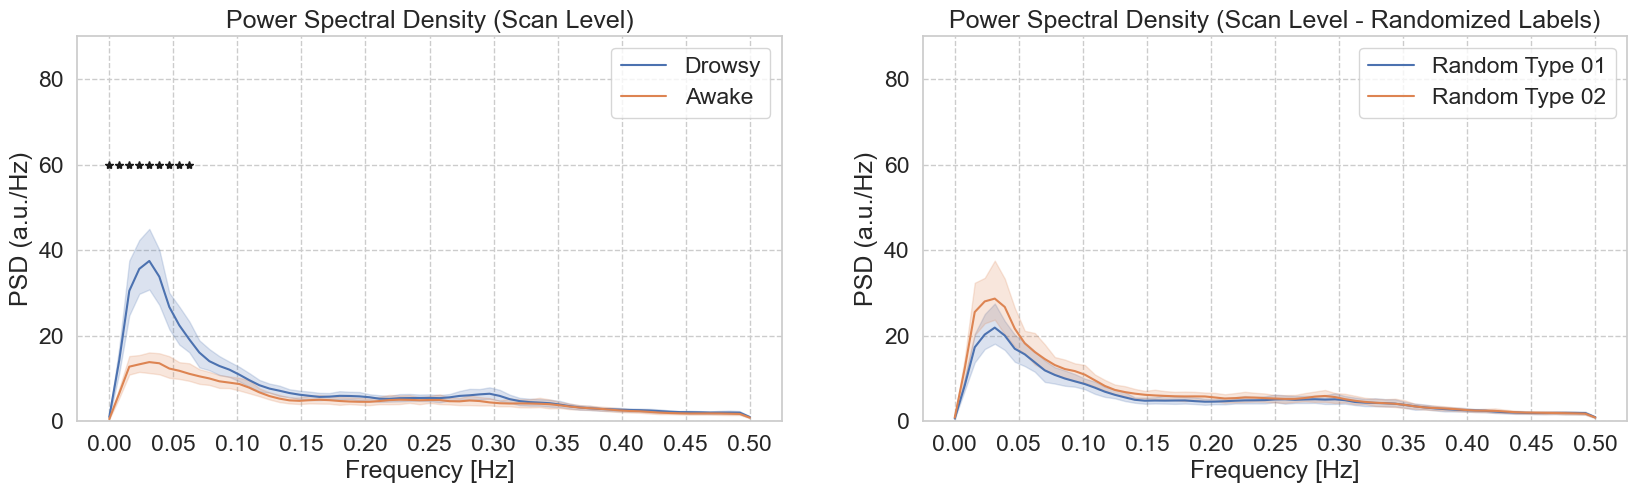

In [14]:
fig

**Same as above, but with logarithmic scale**

In [18]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid",{"xtick.major.size": 0.1,
    "xtick.minor.size": 0.05,'grid.linestyle': '--'})
fig, axs   = plt.subplots(1,2,figsize=(20,5))
# Plot Real Data
sns.lineplot(data=stacked_data[stacked_data['Scan Type'].isin(['Awake','Drowsy'])], 
             x='Frequency [Hz]', 
             hue='Scan Type', hue_order=['Drowsy','Awake'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[0])
axs[0].set_title('Power Spectral Density')
axs[0].legend(ncol=1, loc='upper right')
axs[0].plot(peridiograms_df.index,kw_tests['Bonf_sign'],'k*',lw=1)
axs[0].set_ylim([0,90])
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
axs[0].set(xscale="log")
# Plot Randomized Data
sns.lineplot(data=random_stacked_data[random_stacked_data['Scan Type'].isin(['Random Type 01','Random Type 02'])], 
             x='Frequency [Hz]', 
             hue='Scan Type', hue_order=['Random Type 01','Random Type 02'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[1])
axs[1].set_title('Power Spectral Density (Scan Level - Randomized Labels)')
axs[1].legend(ncol=1, loc='upper right')
axs[1].plot(peridiograms_df.index,random_kw_tests['Bonf_sign'],'k',lw=5)
axs[1].set_ylim([0,90])
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
axs[1].set(xscale="log")

[None]

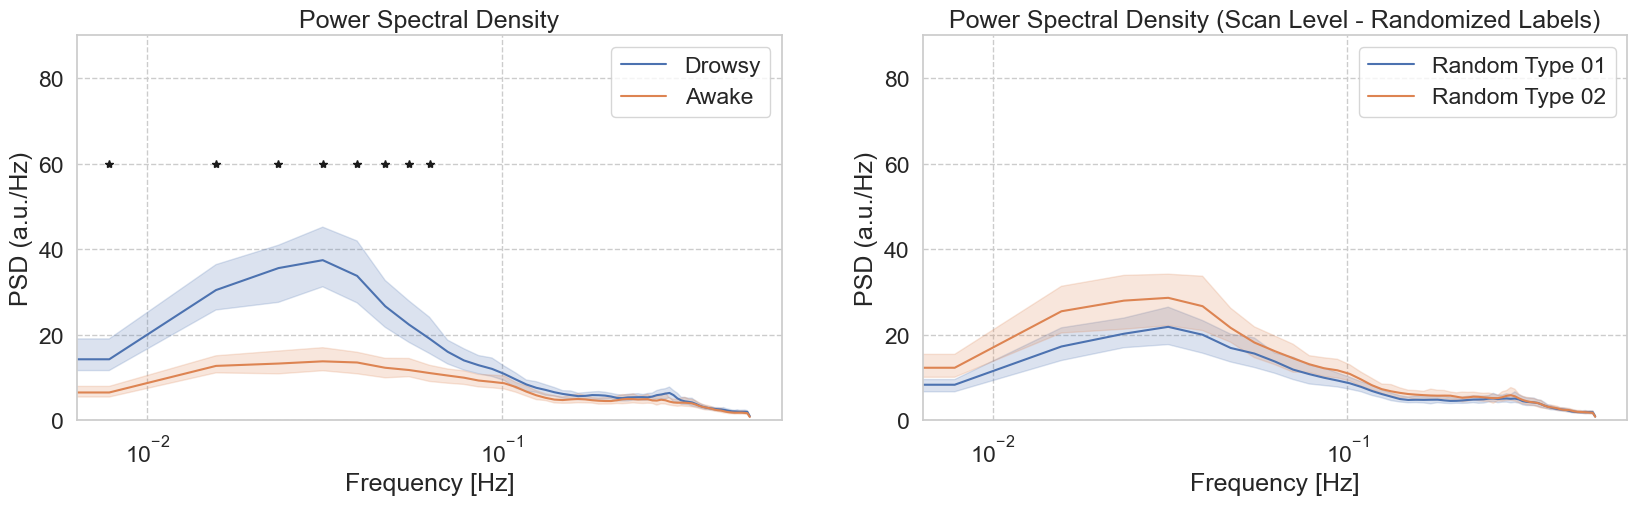

In [19]:
fig

In [17]:
fig.savefig('./figures/Revision1_Figure9_PanelA.{ss}.png'.format(ss=scan_selection))